In [1]:
''' 
SRT2CSV
vsulli
26 April 2025
read in a .srt file 
convert to a df to perform nlp
export to a .csv file for upload to ANKI
'''

import nltk
import numpy as np
import pandas as pd
import pysrt
import re
import seaborn as sns
import spacy
import string

from nltk.corpus import stopwords
german_sw = stopwords.words('german')
from textblob import TextBlob

# allows for displaying multiple outputs in one cell
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import tkinter as tk
from tkinter import filedialog

# keeps full GUI from appearing
root = tk.Tk()
root.withdraw()

# shows dialog box to ask for filename
filename = filedialog.askopenfilename()

''

In [3]:
# specify the encoding if UnicodeDecodeError
# you can open the file in NotePad and check SaveAs for default encoding
# ANSI, UTF-8
subs = pysrt.open(filename, encoding='utf-8')

In [4]:
def remove_formatting(subfile):
    # read through every sub line
    # using regex, delete section of line between <>
    # combine to string
    # update index
    for i in range(len(subfile)):
        # replace all characters between < and > with ""
        # using regex
        # strip white space from beginning
        subfile[i].text = subfile[i].text.lstrip()
        subfile[i].text = re.sub(r'<c.vtt_\w+>\s*"*', "", subfile[i].text)
        subfile[i].text = re.sub("</c>", "", subfile[i].text)
        # replace "-" with ""
        subfile[i].text = re.sub("-", "", subfile[i].text)

    return subfile

In [5]:
subs = remove_formatting(subs)

In [6]:
# create a dataframe with desired column name - 'Subtitle'
def create_dataframe(subfile, col_name):
    # create dataframe
    df = pd.DataFrame(columns=[col_name])
    for i in range(len(subfile)):
        df.loc[i] = subfile[i].text
    return df

In [7]:
# combine rows until period or end character reached
# used for gaining more context for sentiment analysis and classification
# append these rows to list and then create new df - more efficient than appending to df
# end characters at index -1 must be ) . ? ! 
df = create_dataframe(subs, 'Subtitle')
df
new_df_list = []
current_row = ""
for row in df['Subtitle']:
    if row[-1] == ")" or row[-1] == "." or row[-1] == "?" or row[-1] == "!":
        current_row += row
        new_df_list.append(current_row)
        current_row = ""
    else:
        current_row += row

# create new df from the list of combined rows
# currently fewer rows - need to verify that it combined the rows correctly
new_df = pd.DataFrame(new_df_list)
new_df.rename(columns={0:"Subtitle"}, inplace=True)
new_df


,Subtitle
0,<font color=#ffffff>.</font>
1,<font color=#ffffff>(Motor wird angelassen)</f...
2,<font color=#ffffff>Herr Landsberger?</font>\n...
3,<font color=#ffffff>Motorhaube und Kofferraum ...
4,<font color=#ffffff>Machen Sie den Koffer auf!...
...,...
752,<font color=#ffffff>Haben Sie Verwandte in der...
753,<font color=#ffffff>Herr Landsberger?</font>\n...
754,<font color=#ffffff>Herr Trimmel'?</font>
755,<font color=#ffffff>Wohl ein Jugendbildnis von...


""


In [24]:
# create new dataframe removing the subtitle font tags
# go row by row - only include what's between > and < symbols
new_df_list = []
current_row = ""
for i in range(len(df['Subtitle'])):
    # slice between two characters > and < 
    match = re.findall(r'>(.*?)<', df['Subtitle'][i])
    if match:
        new_df_list.append(match[0])
    else:
        new_df_list.append(df['Subtitle'][i])

    
# create new df from the list of combined rows
# currently fewer rows - need to verify that it combined the rows correctly
new_df = pd.DataFrame(new_df_list)
new_df.rename(columns={0:"Subtitle"}, inplace=True)
new_df

,Subtitle
0,.
1,(Motor wird angelassen)
2,Herr Landsberger?
3,"Motorhaube und Kofferraum öffnen,"
4,Machen Sie den Koffer auf!
...,...
752,Haben Sie Verwandte in der DDR?
753,Herr Landsberger?
754,Herr Trimmel'?
755,Wohl ein Jugendbildnis von Ihnen.


In [25]:
# basic exploratory data analysis
def explore_data(dataframe, column):
    print(dataframe.head())
    print(dataframe.shape)
    print(dataframe.dtypes)
    print(dataframe.describe(include='all'))
    
explore_data(new_df, 'Subtitle')

                            Subtitle
0                                  .
1            (Motor wird angelassen)
2                  Herr Landsberger?
3  Motorhaube und Kofferraum öffnen,
4         Machen Sie den Koffer auf!
(757, 1)
Subtitle    object
dtype: object
         Subtitle
count         757
unique        721
top     (Trimmel)
freq            6


In [17]:
# convert to lowercase
def make_lowercase(df):
    df['Lowercase'] = df['Subtitle'].str.lower()
    return df

In [14]:
# remove punctuation
def remove_punctuation(df):
    # starts with any word, digits, or underscore, white space character, + means any character in the string
    df['Lowercase'] = df['Lowercase'].str.replace(r'[^\w\s]+', ' ', regex = True)
    # df['Subtitle'] = df['Subtitle'].str.replace(r'\n', ' ', regex = True) # replaces the \n with a space
    return df

In [15]:
# remove newline \n character
def remove_newline(df):
    df['Subtitle'] = df['Subtitle'].str.replace(r'\n', ' ', regex = True) # replaces the \n with a space
    return df

In [37]:
# remove newline
clean_df = remove_newline(new_df)
print(clean_df.head())

                            Subtitle                          Lowercase  \
0                                  .                                      
1            (Motor wird angelassen)             motor wird angelassen    
2                  Herr Landsberger?                  herr landsberger    
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen    
4         Machen Sie den Koffer auf!         machen sie den koffer auf    

                             Word Tokens                     Sentence Tokens  \
0                                     []                                  []   
1              [motor, wird, angelassen]            [ motor wird angelassen]   
2                    [herr, landsberger]                  [herr landsberger]   
3  [motorhaube, und, kofferraum, öffnen]  [motorhaube und kofferraum öffnen]   
4        [machen, sie, den, koffer, auf]         [machen sie den koffer auf]   

                      no_stop_words                     No Stop Word

In [27]:
# make lowercase
clean_df = make_lowercase(clean_df)
print(clean_df.head())

                            Subtitle                          Lowercase
0                                  .                                  .
1            (Motor wird angelassen)            (motor wird angelassen)
2                  Herr Landsberger?                  herr landsberger?
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen,
4         Machen Sie den Koffer auf!         machen sie den koffer auf!


In [28]:
# remove punctuation
clean_df = remove_punctuation(clean_df)
print(clean_df.head())
clean_df[100:101]

                            Subtitle                          Lowercase
0                                  .                                   
1            (Motor wird angelassen)             motor wird angelassen 
2                  Herr Landsberger?                  herr landsberger 
3  Motorhaube und Kofferraum öffnen,  motorhaube und kofferraum öffnen 
4         Machen Sie den Koffer auf!         machen sie den koffer auf 


,Subtitle,Lowercase
100,In Leipzig gekauft.,in leipzig gekauft


In [29]:
clean_df['Word Tokens'] = clean_df['Lowercase'].apply(nltk.word_tokenize)

In [31]:
clean_df['Word Tokens']

0                                          []
1                   [motor, wird, angelassen]
2                         [herr, landsberger]
3       [motorhaube, und, kofferraum, öffnen]
4             [machen, sie, den, koffer, auf]
                        ...                  
752     [haben, sie, verwandte, in, der, ddr]
753                       [herr, landsberger]
754                           [herr, trimmel]
755    [wohl, ein, jugendbildnis, von, ihnen]
756                                        []
Name: Word Tokens, Length: 757, dtype: object

In [32]:
clean_df['Sentence Tokens'] = clean_df['Lowercase'].apply(nltk.sent_tokenize)

In [33]:
clean_df['Sentence Tokens']

0                                      []
1                [ motor wird angelassen]
2                      [herr landsberger]
3      [motorhaube und kofferraum öffnen]
4             [machen sie den koffer auf]
                      ...                
752      [haben sie verwandte in der ddr]
753                    [herr landsberger]
754                        [herr trimmel]
755    [wohl ein jugendbildnis von ihnen]
756                                    []
Name: Sentence Tokens, Length: 757, dtype: object

In [41]:
# remove stopwords

# have to extend stopwords to include names of characters & places
custom_stop_words = ['hamburg', 'berlin', 'leipzig', 'elise', 'christian', 'berti', 'eva', 'chris', 'landsberger', 'trimmel']
german_sw.extend(custom_stop_words)

clean_df['No Stop Words'] = clean_df['Word Tokens'].apply(lambda x: [item for item in x if item not in german_sw])
clean_df[100:120]

,Subtitle,Lowercase,Word Tokens,Sentence Tokens,no_stop_words,No Stop Words
100,In Leipzig gekauft.,in leipzig gekauft,"[in, leipzig, gekauft]",[in leipzig gekauft],"[leipzig, gekauft]",[gekauft]
101,Musst du immer kurze Röcke tragen?,musst du immer kurze röcke tragen,"[musst, du, immer, kurze, röcke, tragen]",[musst du immer kurze röcke tragen],"[musst, immer, kurze, röcke, tragen]","[musst, immer, kurze, röcke, tragen]"
102,Jetzt reicht's.,jetzt reicht s,"[jetzt, reicht, s]",[jetzt reicht s],"[reicht, s]","[reicht, s]"
103,Hast du vor mir noch nie,hast du vor mir noch nie,"[hast, du, vor, mir, noch, nie]",[hast du vor mir noch nie],"[hast, nie]","[hast, nie]"
104,Für wen mache ich das alles?,für wen mache ich das alles,"[für, wen, mache, ich, das, alles]",[für wen mache ich das alles],"[wen, mache]","[wen, mache]"
105,Für Erich,für erich,"[für, erich]",[für erich],[erich],[erich]
106,"Für uns beide, dachte ich.",für uns beide dachte ich,"[für, uns, beide, dachte, ich]",[für uns beide dachte ich],"[beide, dachte]","[beide, dachte]"
107,Da kannst du alleine,da kannst du alleine,"[da, kannst, du, alleine]",[da kannst du alleine],"[kannst, alleine]","[kannst, alleine]"
108,Ich lass mir wegen dem,ich lass mir wegen dem,"[ich, lass, mir, wegen, dem]",[ich lass mir wegen dem],"[lass, wegen]","[lass, wegen]"
109,(Tür knallt),tür knallt,"[tür, knallt]",[ tür knallt],"[tür, knallt]","[tür, knallt]"


In [42]:
clean_df[100:101]['Subtitle']
clean_df[0:20]['No Stop Words']

100    In Leipzig gekauft.
Name: Subtitle, dtype: object

0                                      []
1                     [motor, angelassen]
2                                  [herr]
3        [motorhaube, kofferraum, öffnen]
4                                [koffer]
5                       [sitzbank, bitte]
6                         [kind, schläft]
7                   [außerdem, geht, gut]
8                         [handschuhfach]
9                                 [danke]
10                               [hörbar]
11                                [hörst]
12    [ärmliche, nee, förmliche, anfrage]
13              [strafverfolgungsbehörde]
14                            [rastplatz]
15                          [fand, toten]
16                         [verletzungen]
17                            [lies, mal]
18              [trug, kind, ddrkleidung]
19                                 [geht]
Name: No Stop Words, dtype: object

In [43]:
# create a frequency diagram without stop words

# list of all words
words = []
for index, row in clean_df.iterrows():
    for word in row['No Stop Words']:
        words.append(word)
words[0:20]

['motor',
 'angelassen',
 'herr',
 'motorhaube',
 'kofferraum',
 'öffnen',
 'koffer',
 'sitzbank',
 'bitte',
 'kind',
 'schläft',
 'außerdem',
 'geht',
 'gut',
 'handschuhfach',
 'danke',
 'hörbar',
 'hörst',
 'ärmliche',
 'nee']

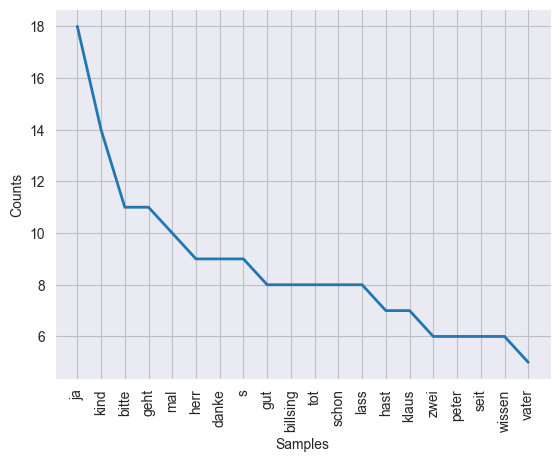

<Axes: xlabel='Samples', ylabel='Counts'>

In [44]:
# plot the word frequency
sns.set_style('darkgrid')
freq_words = nltk.FreqDist(words)
freq_words.plot(20)

In [ ]:
# TODO

# Notepad++ convert ANSI to UTF-8 for special characters
# seems to need to be UTF-8 BOM in order to preserve special characters

# remove font color tags
# everything from < to > 
# <font color=#ffffff>(Motor wird angelassen)</font>

# fix removing of punctuation to keep " ' " character for contractions

# add a way to read-in stop words & words you've already seen from a file (JSON dict?)

# add export of all sentences to a .csv file
# fields 
    # DEU     # dict def of no-stop-words column    # tags
    
